# 作業重點:

(1)以, Adam, 為例, 調整 batch_size, epoch , 觀察accurancy, loss 的變化

(2)以同一模型, 分別驗證 SGD, Adam, Rmsprop 的 accurancy

# 作業目標:
    
    取得各種優化器的運算結果

In [17]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os
from keras import optimizers

In [18]:
#Blas GEMM launch failed, 避免動態分配GPU / CPU, 出現問題（本電腦無GPU）
#import tensorflow as tf
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
#sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [20]:
'''
   宣告並設定
   batch_size：對總的樣本數進行分組，每組包含的樣本數量
   epochs：訓練次數
''' 
batch_size = 64
epochs = 10
num_classes = 10
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')

In [21]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [22]:
#    第一步：選擇模型, 順序模型是多個網絡層的線性堆疊
 
model = Sequential()

#   第二步：構建網絡層
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(10)) # 輸出結果是10個類別，所以維度是10   
model.add(Activation('softmax')) # 最後一層用softmax作為激活函數

In [23]:
# 模型建立完成後，統計參數總量
import copy
model_SGD = copy.deepcopy(model)
model_RMS = copy.deepcopy(model)
print("Total Parameters：%d" % model.count_params())

Total Parameters：1250858


In [24]:
# 輸出模型摘要資訊
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_13 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_14 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 64)        18496     
__________

In [25]:
#第三步編譯
'''
SGD(隨機梯度下降) - Arguments
lr: float >= 0. Learning rate.
momentum: float >= 0. Parameter that accelerates SGD in the relevant direction and dampens oscillations.
decay: float >= 0. Learning rate decay over each update.
nesterov: boolean. Whether to apply Nesterov momentum.

RMSprop - Arguments
lr: float >= 0. Learning rate.
rho: float >= 0.
epsilon: float >= 0. Fuzz factor. If None, defaults to K.epsilon().
decay: float >= 0. Learning rate decay over each update.
'''
opt_RMS = optimizers.rmsprop(lr=0.01, decay=1e-6, rho=0.8)
opt_SGD = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model_SGD.compile(optimizer = opt_SGD, loss = 'categorical_crossentropy', metrics = ['accuracy'])
model_RMS.compile(optimizer = opt_RMS, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [26]:
# 資料正規化
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [28]:
# 是否要做資料處理
'''
   第四步：訓練
   .fit的一些參數
   batch_size：對總的樣本數進行分組，每組包含的樣本數量
   epochs ：訓練次數
   shuffle：是否把數據隨機打亂之後再進行訓練
   validation_split：拿出百分之多少用來做交叉驗證
   verbose：屏顯模式 - 0：不輸出, 1：輸出進度, 2：輸出每次的訓練結果
'''
import numpy 
history = []
for NAME, MODEL in zip(['', '_SGN', '_RMS'], [model, model_SGD, model_RMS]):
    model_name = 'keras_cifar10_trained_model'+NAME+'.h5'
    if not data_augmentation:
        print('Not using data augmentation.')
        history.append(
            MODEL.fit(
                x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), shuffle=True
            )
        )
    else:
        print('Using real-time data augmentation.')
        print('')

        # This will do preprocessing and realtime data augmentation:
        datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            zca_epsilon=1e-06,  # epsilon for ZCA whitening
            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
            # randomly shift images horizontally (fraction of total width)
            width_shift_range=0.1,
            # randomly shift images vertically (fraction of total height)
            height_shift_range=0.1,
            shear_range=0.,  # set range for random shear
            zoom_range=0.,  # set range for random zoom
            channel_shift_range=0.,  # set range for random channel shifts
            # set mode for filling points outside the input boundaries
            fill_mode='nearest',
            cval=0.,  # value used for fill_mode = "constant"
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False,  # randomly flip images
            # set rescaling factor (applied before any other transformation)
            rescale=None,
            # set function that will be applied on each input
            preprocessing_function=None,
            # image data format, either "channels_first" or "channels_last"
            data_format=None,
            # fraction of images reserved for validation (strictly between 0 and 1)
            validation_split=0.0)

        # Compute quantities required for feature-wise normalization
        # (std, mean, and principal components if ZCA whitening is applied).
        datagen.fit(x_train)
        history.append(
            MODEL.fit(
                x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), shuffle=True
            )
        ) 
    # Save model and weights
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    MODEL.save(model_path)
    print('Saved trained model at %s ' % model_path)

    scores = MODEL.evaluate(x_test, y_test, verbose=1)
    print('Test loss:', scores[0])
    print('Test accuracy:', scores[1])

    # 第六步：輸出
    print("Test Set")
    scores = MODEL.evaluate(x_test, y_test, batch_size=200, verbose= 0)
    print("The test loss is %f ", scores)

    result = MODEL.predict(x_test, batch_size=200, verbose= 0)

    result_max = numpy.argmax(result, axis = 1 )
    test_max = numpy.argmax(y_test, axis = 1 )

    result_bool = numpy.equal(result_max, test_max)
    true_num = numpy.sum(result_bool)

Using real-time data augmentation.



W0825 21:55:15.857807 4571411904 deprecation.py:323] From /Users/bobchien/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 130s 3ms/step - loss: 1.5775 - acc: 0.4224 - val_loss: 1.1896 - val_acc: 0.5763
Epoch 2/10
50000/50000 [==============================] - 135s 3ms/step - loss: 1.1472 - acc: 0.5938 - val_loss: 0.9507 - val_acc: 0.6640
Epoch 3/10
50000/50000 [==============================] - 135s 3ms/step - loss: 0.9741 - acc: 0.6572 - val_loss: 0.8586 - val_acc: 0.6964
Epoch 4/10
50000/50000 [==============================] - 131s 3ms/step - loss: 0.8657 - acc: 0.6962 - val_loss: 0.7758 - val_acc: 0.7306
Epoch 5/10
50000/50000 [==============================] - 117s 2ms/step - loss: 0.8014 - acc: 0.7179 - val_loss: 0.7492 - val_acc: 0.7375
Epoch 6/10
50000/50000 [==============================] - 121s 2ms/step - loss: 0.7506 - acc: 0.7363 - val_loss: 0.7313 - val_acc: 0.7430
Epoch 7/10
50000/50000 [==============================] - 137s 3ms/step - loss: 0.6994 - acc: 0.7548 - val_loss: 0.6858 - 

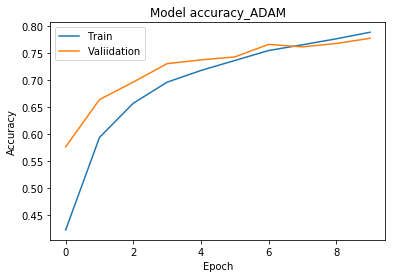

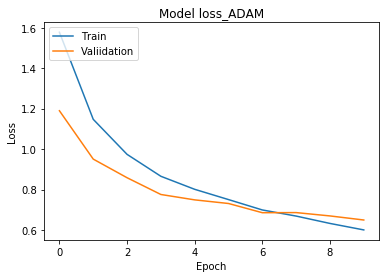

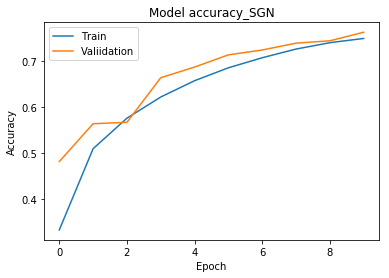

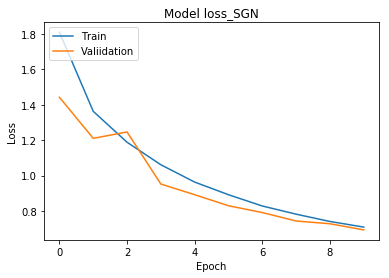

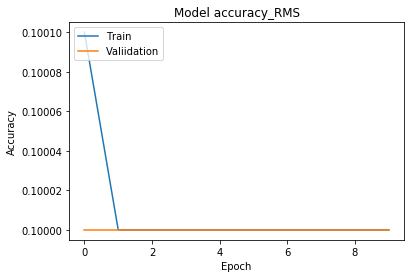

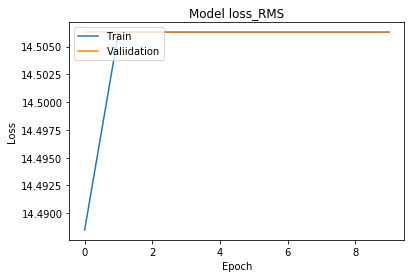

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

for h, n in zip(history, ['_ADAM', '_SGN', '_RMS']):
    # Plot training & validation accuracy values
    plt.plot(h.history['acc'])
    plt.plot(h.history['val_acc'])
    plt.title('Model accuracy' + n)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valiidation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(h.history['loss'])
    plt.plot(h.history['val_loss'])
    plt.title('Model loss' + n)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valiidation'], loc='upper left')
    plt.show()